# Problem Statement

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola.

Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly.

Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition.

You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

Demographics (city, age, gender etc.)

Tenure information (joining date, Last Date)

Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

## Column Profiling:

MMMM-YY : Reporting Date (Monthly)

Driver_ID : Unique id for drivers

Age : Age of the driver

Gender : Gender of the driver – Male : 0, Female: 1

City : City Code of the driver

Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate

Income : Monthly average Income of the driver

Date Of Joining : Joining date for the driver

LastWorkingDate : Last date of working for the driver

Joining Designation : Designation of the driver at the time of joining

Grade : Grade of the driver at the time of reporting

Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)

Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

# Installing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve

import time

In [2]:
data = pd.read_csv("/content/Ola-ensemble_learning.csv")

data.head()

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [3]:
data.drop("Unnamed: 0", axis = 1, inplace = True)

In [4]:
data.head()

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [5]:
data.shape

(19104, 13)

In [6]:
data.nunique()

,0
MMM-YY,24
Driver_ID,2381
Age,36
Gender,2
City,29
Education_Level,3
Income,2383
Dateofjoining,869
LastWorkingDate,493
Joining Designation,5


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


# Converting features to data-types

In [8]:
data["MMM-YY"] = pd.to_datetime(data["MMM-YY"])
data["Dateofjoining"] = pd.to_datetime(data["Dateofjoining"])
data["LastWorkingDate"] = pd.to_datetime(data["LastWorkingDate"])

<ipython-input-8-1a156762d6cb>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["MMM-YY"] = pd.to_datetime(data["MMM-YY"])
<ipython-input-8-1a156762d6cb>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Dateofjoining"] = pd.to_datetime(data["Dateofjoining"])
<ipython-input-8-1a156762d6cb>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["LastWorkingDate"] = pd.to_datetime(data["LastWorkingDate"])


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

# Check for missing values

In [10]:
data.isnull().sum() / len(data) * 100

,0
MMM-YY,0.000000
Driver_ID,0.000000
Age,0.319305
Gender,0.272194
City,0.000000
Education_Level,0.000000
Income,0.000000
Dateofjoining,0.000000
LastWorkingDate,91.541039
Joining Designation,0.000000


In [11]:
num_vars = data.select_dtypes(np.number)

num_vars.columns

Index(['Driver_ID', 'Age', 'Gender', 'Education_Level', 'Income',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

In [12]:
num_vars.drop(["Driver_ID"], axis = 1, inplace = True)

# Prepare data for KNN Imputation

In [13]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(num_vars)
data_new = imputer.transform(num_vars)

In [14]:
data_new = pd.DataFrame(data_new)

In [15]:
data_new.columns = num_vars.columns

In [16]:
data_new.isnull().sum()

,0
Age,0
Gender,0
Education_Level,0
Income,0
Joining Designation,0
Grade,0
Total Business Value,0
Quarterly Rating,0


In [17]:
data_new.nunique()

,0
Age,70
Gender,6
Education_Level,3
Income,2383
Joining Designation,5
Grade,5
Total Business Value,10181
Quarterly Rating,4


# Concatenate dataframes

In [18]:
resultant_columns = list(set(data.columns).difference(set(num_vars)))

resultant_columns

['Dateofjoining', 'LastWorkingDate', 'MMM-YY', 'Driver_ID', 'City']

In [19]:
new_df = pd.concat([data_new, data[resultant_columns]], axis=1)

new_df.shape

(19104, 13)

In [20]:
new_df.head()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Dateofjoining,LastWorkingDate,MMM-YY,Driver_ID,City
0,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0,2018-12-24,NaT,2019-01-01,1,C23
1,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0,2018-12-24,NaT,2019-02-01,1,C23
2,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0,2018-12-24,2019-03-11,2019-03-01,1,C23
3,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2020-11-06,NaT,2020-11-01,2,C7
4,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2020-11-06,NaT,2020-12-01,2,C7


# Feature Engineering

In [21]:
agg_functions = {
    "Age": "max",
    "Gender": "first",
    "Education_Level": "last",
    "Income": "last",
    "Joining Designation": "last",
    "Grade": "last",
    "Total Business Value": "sum",
    "Quarterly Rating": "last",
    "LastWorkingDate": "last",
    "City": "first",
    "Dateofjoining": "last"
}


In [22]:
processed_df = new_df.groupby(["Driver_ID", "MMM-YY"]).aggregate(agg_functions).sort_index(ascending = [True, True])

processed_df.head()

Age  Gender  Education_Level   Income  \
Driver_ID MMM-YY                                               
1         2019-01-01  28.0     0.0              2.0  57387.0   
          2019-02-01  28.0     0.0              2.0  57387.0   
          2019-03-01  28.0     0.0              2.0  57387.0   
2         2020-11-01  31.0     0.0              2.0  67016.0   
          2020-12-01  31.0     0.0              2.0  67016.0   

                      Joining Designation  Grade  Total Business Value  \
Driver_ID MMM-YY                                                         
1         2019-01-01                  1.0    1.0             2381060.0   
          2019-02-01                  1.0    1.0             -665480.0   
          2019-03-01                  1.0    1.0                   0.0   
2         2020-11-01                  2.0    2.0                   0.0   
          2020-12-01                  2.0    2.0                   0.0   

                      Quarterly Rating LastWorkingDate City Dateofjoining  
Driver_ID MMM-YY                                                           
1         2019-01-01               2.0             NaT  C23    2018-12-24  
          2019-02-01               2.0             NaT  C23    2018-12-24  
          2019-03-01               2.0      2019-03-11  C23    2018-12-24  
2         2020-11-01               1.0             NaT   C7    2020-11-06  
          2020-12-01               1.0             NaT   C7    2020-11-06

In [23]:
final_data = pd.DataFrame()

In [24]:
final_data["Driver_ID"] = new_df["Driver_ID"].unique()

In [25]:
final_data['Age'] = list(processed_df.groupby('Driver_ID',axis=0).max('MMM-YY')['Age'])
final_data['Gender'] = list(processed_df.groupby('Driver_ID').agg({'Gender':'last'})['Gender'])
final_data['City'] = list(processed_df.groupby('Driver_ID').agg({'City':'last'})['City'])
final_data['Education'] = list(processed_df.groupby('Driver_ID').agg({'Education_Level':'last'})['Education_Level'])
final_data['Income'] = list(processed_df.groupby('Driver_ID').agg({'Income':'last'})['Income'])
final_data['Joining_Designation'] = list(processed_df.groupby('Driver_ID').agg({'Joining Designation':'last'})['Joining Designation'])
final_data['Grade'] = list(processed_df.groupby('Driver_ID').agg({'Grade':'last'})['Grade'])
final_data['Total_Business_Value'] = list(processed_df.groupby('Driver_ID',axis=0).sum('Total Business Value')['Total Business Value'])
final_data['Last_Quarterly_Rating'] = list(processed_df.groupby('Driver_ID').agg({'Quarterly Rating':'last'})['Quarterly Rating'])



final_data.head()

<ipython-input-25-2a545526c688>:1: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  final_data['Age'] = list(processed_df.groupby('Driver_ID',axis=0).max('MMM-YY')['Age'])
<ipython-input-25-2a545526c688>:8: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  final_data['Total_Business_Value'] = list(processed_df.groupby('Driver_ID',axis=0).sum('Total Business Value')['Total Business Value'])


,Driver_ID,Age,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0


In [26]:
final_data.shape

(2381, 10)

# Create a column which tells whether the quarterly rating has increased for that driver

# Assign the value 1

In [27]:
first_quarter = processed_df.groupby(["Driver_ID"]).agg({"Quarterly Rating": "first"})

last_quarter = processed_df.groupby(["Driver_ID"]).agg({"Quarterly Rating": "last"})

qr = (last_quarter["Quarterly Rating"] > first_quarter["Quarterly Rating"]).reset_index()

empid = qr[qr["Quarterly Rating"] == True]["Driver_ID"]

qrl = []
for i in final_data["Driver_ID"]:
    if i in empid.values:
        qrl.append(1)
    else:
        qrl.append(0)


final_data["Quarterly_Rating_Increased"] = qrl

In [28]:
final_data.head()

,Driver_ID,Age,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0,0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0,0
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0,0
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0,1


# Create a column called target which tells whether the driver has left the company

In [29]:
lwd = (processed_df.groupby(["Driver_ID"]).agg({"LastWorkingDate": "last"})["LastWorkingDate"].isna()).reset_index()

lwrid = lwd[lwd["LastWorkingDate"] == True]["Driver_ID"]
target = []

for i in final_data["Driver_ID"]:
    if i in lwrid.values:
        target.append(0)
    else:
        target.append(1)

final_data["target"] = target

In [30]:
final_data.head()

,Driver_ID,Age,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased,target
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0,0,1
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0,0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0,0,1
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0,0,1
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0,1,0


# Create a column which tells whether the monthly income has increased for that driver

# Assign the value 1

In [31]:
mrf = processed_df.groupby(["Driver_ID"]).agg({"Income": "first"})

mrl = processed_df.groupby(["Driver_ID"]).agg({"Income": "last"})

mr = (mrl["Income"] > mrf["Income"]).reset_index()

empid = mr[mr["Income"] == True]["Driver_ID"]
income = []
for i in final_data["Driver_ID"]:
    if i in empid.values:
        income.append(1)
    else:
        income.append(0)

final_data["Salary_Increased"] = income

In [32]:
final_data.head()

,Driver_ID,Age,Gender,City,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased,target,Salary_Increased
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0,0,1,0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0,0,0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0,0,1,0
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0,0,1,0
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0,1,0,0


In [33]:
final_data["Salary_Increased"].value_counts(normalize=True)

,proportion
Salary_Increased,
0,0.98194
1,0.01806


In [34]:
final_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Driver_ID,2381.0,1.397559e+03,8.061616e+02,1.0,695.0,1400.0,2100.0,2788.0
Age,2381.0,3.377018e+01,5.933265e+00,21.0,30.0,33.0,37.0,58.0
Gender,2381.0,4.105838e-01,4.914963e-01,0.0,0.0,0.0,1.0,1.0
Education,2381.0,1.007560e+00,8.162900e-01,0.0,0.0,1.0,2.0,2.0
Income,2381.0,5.933416e+04,2.838367e+04,10747.0,39104.0,55315.0,75986.0,188418.0
Joining_Designation,2381.0,1.820244e+00,8.414334e-01,1.0,1.0,2.0,2.0,5.0
Grade,2381.0,2.096598e+00,9.415218e-01,1.0,1.0,2.0,3.0,5.0
Total_Business_Value,2381.0,4.586742e+06,9.127115e+06,-1385530.0,0.0,817680.0,4173650.0,95331060.0
Last_Quarterly_Rating,2381.0,1.427971e+00,8.098389e-01,1.0,1.0,1.0,2.0,4.0
Quarterly_Rating_Increased,2381.0,1.503570e-01,3.574961e-01,0.0,0.0,0.0,0.0,1.0


## Observation

There are 2831 distinct driver data points in all.

Drivers are between the ages of 21 and 58.

The monthly salary of 75% of drivers is less than 75986.

The overall business value acquired by 75% of drivers was 4173650.


In [35]:
final_data.describe(include = 'object')

,City
count,2381
unique,29
top,C20
freq,152


The majority of drivers originate in C20 city.

In [36]:
final_data["Gender"].value_counts()

,count
Gender,
0.0,1400
1.0,975
0.6,3
0.2,2
0.4,1


Mojority of drivers are male

In [37]:
final_data["Education"].value_counts()

,count
Education,
2.0,802
1.0,795
0.0,784


Majority of drivers have completed their graduation.

In [38]:
final_data["target"].value_counts()

,count
target,
1,1616
0,765


Out of 2381 drivers 1616 have left the company.

In [39]:
n = ['Gender','Education','Joining_Designation','Grade','Last_Quarterly_Rating','Quarterly_Rating_Increased']

for i in n:
    print("------------------------------------------------------------")
    print(final_data[i].value_counts(normalize=True) * 100)

------------------------------------------------------------
Gender
0.0    58.798824
1.0    40.949181
0.6     0.125997
0.2     0.083998
0.4     0.041999
Name: proportion, dtype: float64
------------------------------------------------------------
Education
2.0    33.683326
1.0    33.389332
0.0    32.927341
Name: proportion, dtype: float64
------------------------------------------------------------
Joining_Designation
1.0    43.091138
2.0    34.229315
3.0    20.705586
4.0     1.511970
5.0     0.461991
Name: proportion, dtype: float64
------------------------------------------------------------
Grade
2.0    35.909282
1.0    31.121378
3.0    26.165477
4.0     5.795884
5.0     1.007980
Name: proportion, dtype: float64
------------------------------------------------------------
Last_Quarterly_Rating
1.0    73.246535
2.0    15.203696
3.0     7.055859
4.0     4.493910
Name: proportion, dtype: float64
------------------------------------------------------------
Quarterly_Rating_Increased
0  

## Observation

Men make about 58% of drivers, whereas women make up about 40%.

Thirty-three percent of drivers are graduates with at least a high school diploma.

One is the joining_designation for 43% of drivers.

About 36% of drivers received a 2 rating.

Last quarter, almost 73% of drivers received a rating of 1.

On a quarterly basis, only 15% of drivers' ratings have grown.


# Univariate Analysis

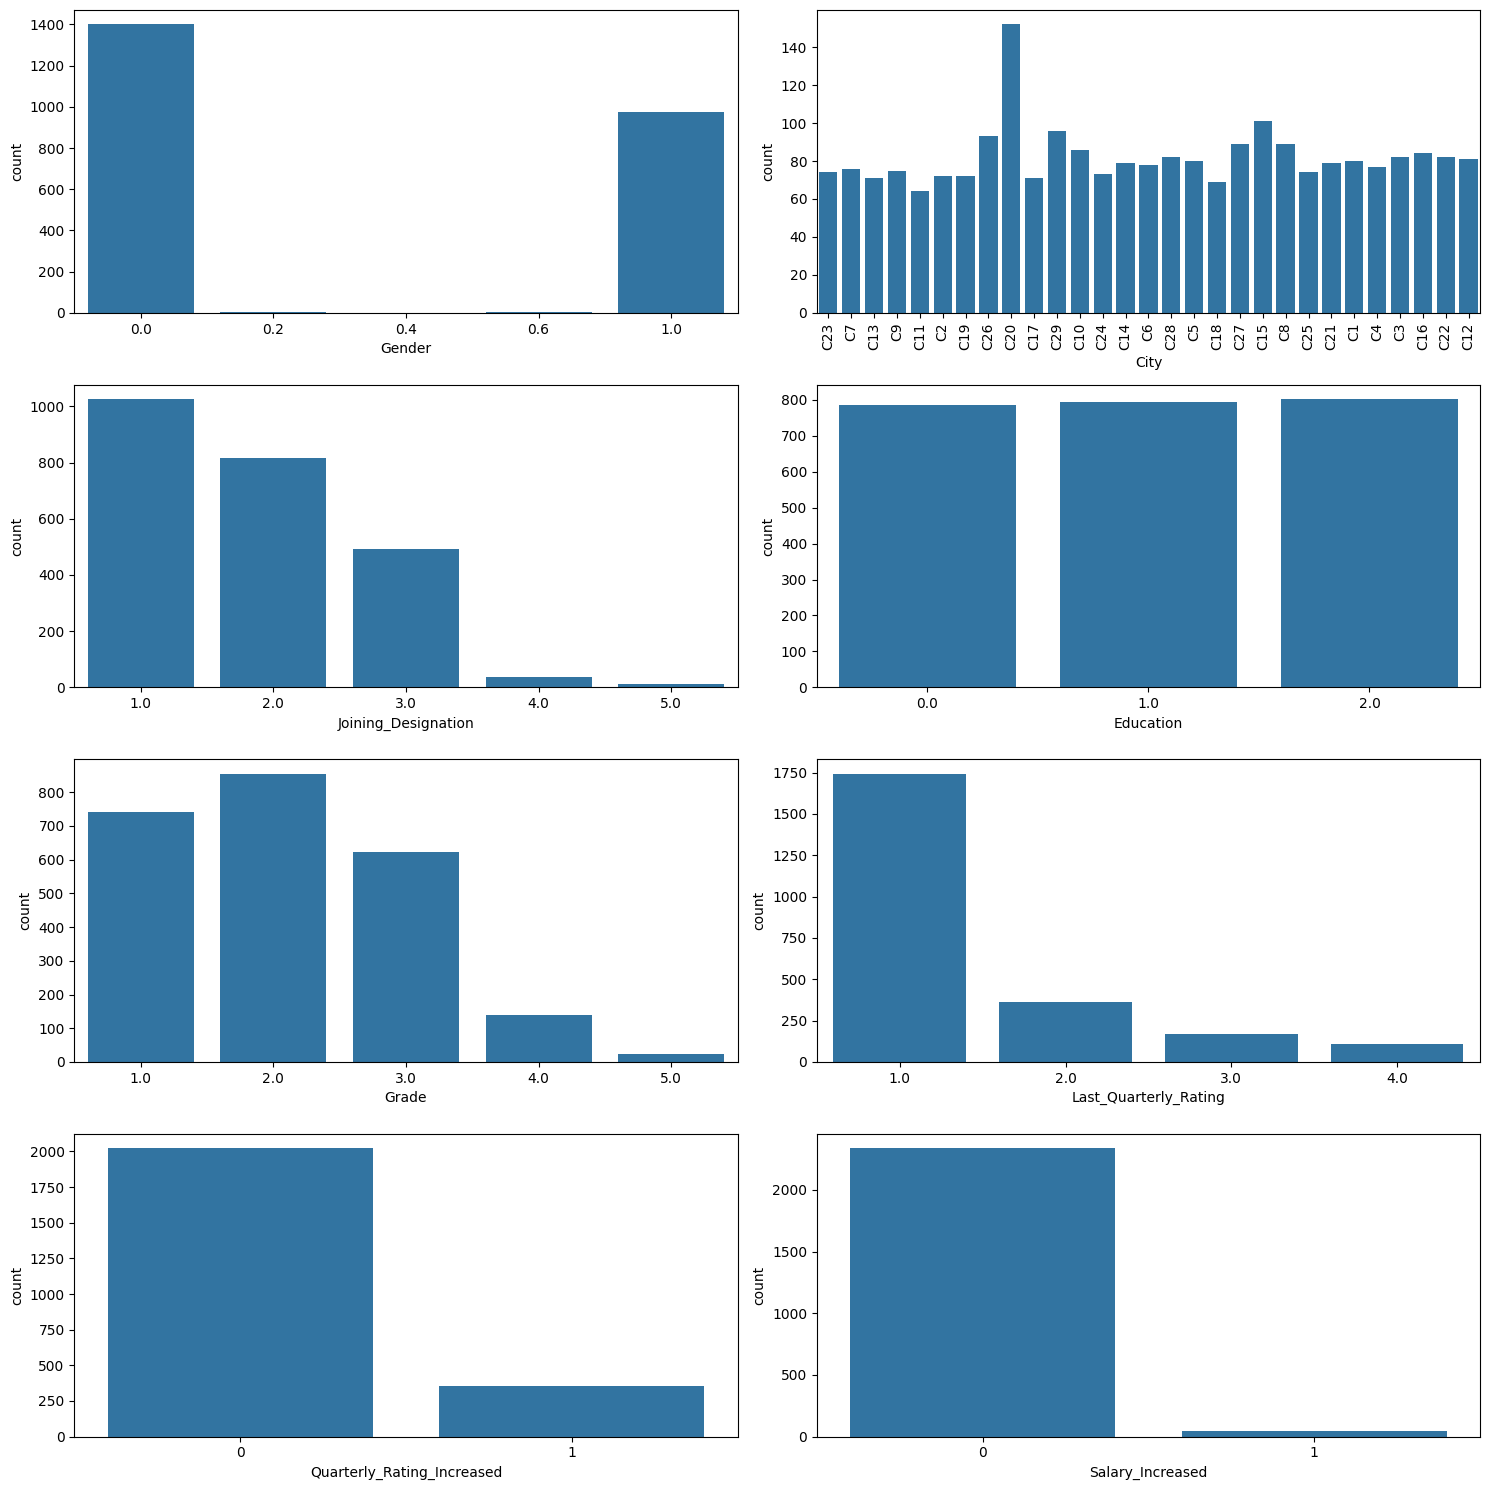

In [40]:
plt.figure(figsize=(15, 15))
plt.subplot(421)
sns.countplot(data=final_data, x="Gender")
# final_data["Gender"].value_counts(normalize=True).plot.bar('Gender')

plt.subplot(422)
sns.countplot(data=final_data, x="City")
plt.xticks(rotation="vertical")

plt.subplot(423)
sns.countplot(data=final_data, x="Joining_Designation")

plt.subplot(424)
sns.countplot(data=final_data, x="Education")

plt.subplot(425)
sns.countplot(data=final_data, x="Grade")

plt.subplot(426)
sns.countplot(data=final_data, x="Last_Quarterly_Rating")

plt.subplot(427)
sns.countplot(data=final_data, x="Quarterly_Rating_Increased")

plt.subplot(428)
sns.countplot(data=final_data, x="Salary_Increased")

plt.tight_layout()

## Observation

There are 977 female employees and 1404 male employees out of 2381 total.

Of the 2381 workers, 101 are from city C15 and 152 are from city C20.

Of the 2381 employees, 795 have finished their 12th grade education, and 802 hold a graduate degree.

Of the 2381 workers, 1026 joined with a grade of 1, and 815 joined with a grade of 2.

At the time of reporting, 855 out of 2381 employees were designated as 2.

1744 employees out of 2381 received a rating of 1 during the most recent quarter.

The quarterly rating has not gone up for 2076 of the 2381 employees.


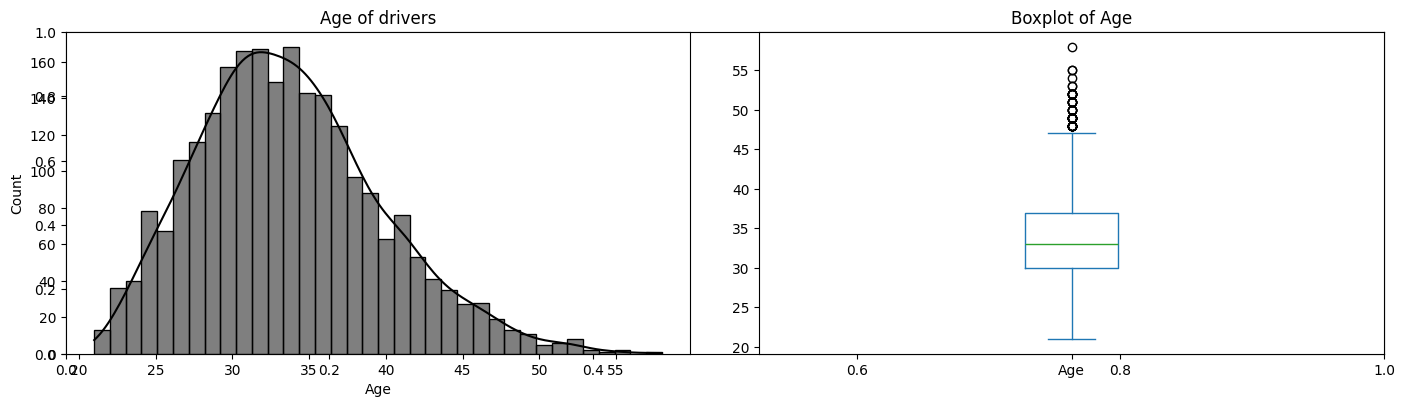

In [41]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
sns.histplot(final_data['Age'],color='black', kde=True)
plt.title("Age of drivers")
plt.subplot(122)
final_data['Age'].plot.box(title='Boxplot of Age')
plt.tight_layout(pad=3)

The age distribution is slightly skewed to the right, which could be a sign of data outliers.

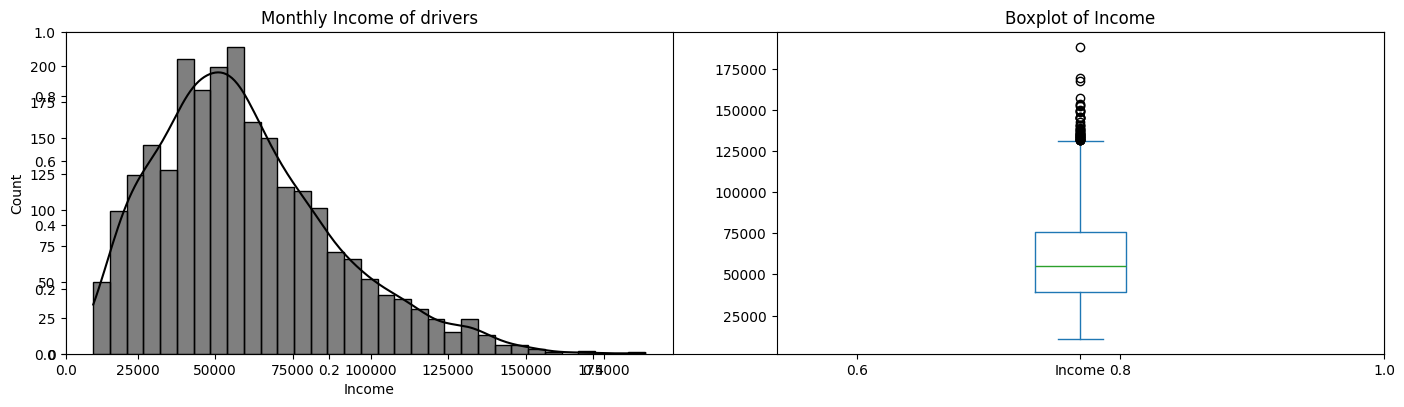

In [42]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
sns.histplot(final_data['Income'],color='black', kde=True)
plt.title("Monthly Income of drivers")
plt.subplot(122)
final_data['Income'].plot.box(title='Boxplot of Income')
plt.tight_layout(pad=3)

The monthly income distribution is skewed to the right, which could be a sign of data outliers.

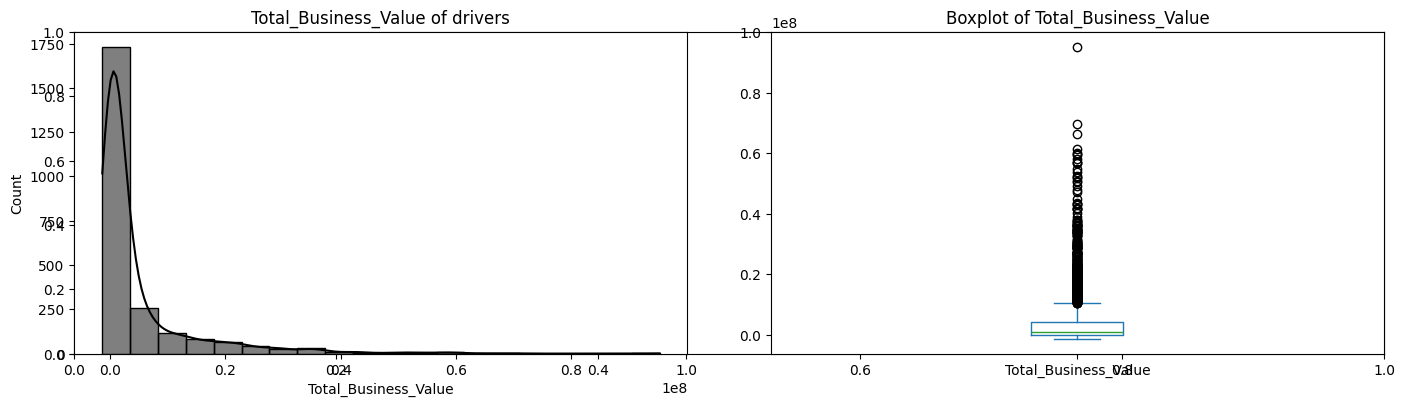

In [43]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
sns.histplot(final_data['Total_Business_Value'],color='black', kde=True, bins=20)
plt.title("Total_Business_Value of drivers")
plt.subplot(122)
final_data['Total_Business_Value'].plot.box(title='Boxplot of Total_Business_Value')
plt.tight_layout(pad=3)

The whole business value distribution is heavily skewed to the right, which could point to data outliers.

# Bi-Variate Analysis

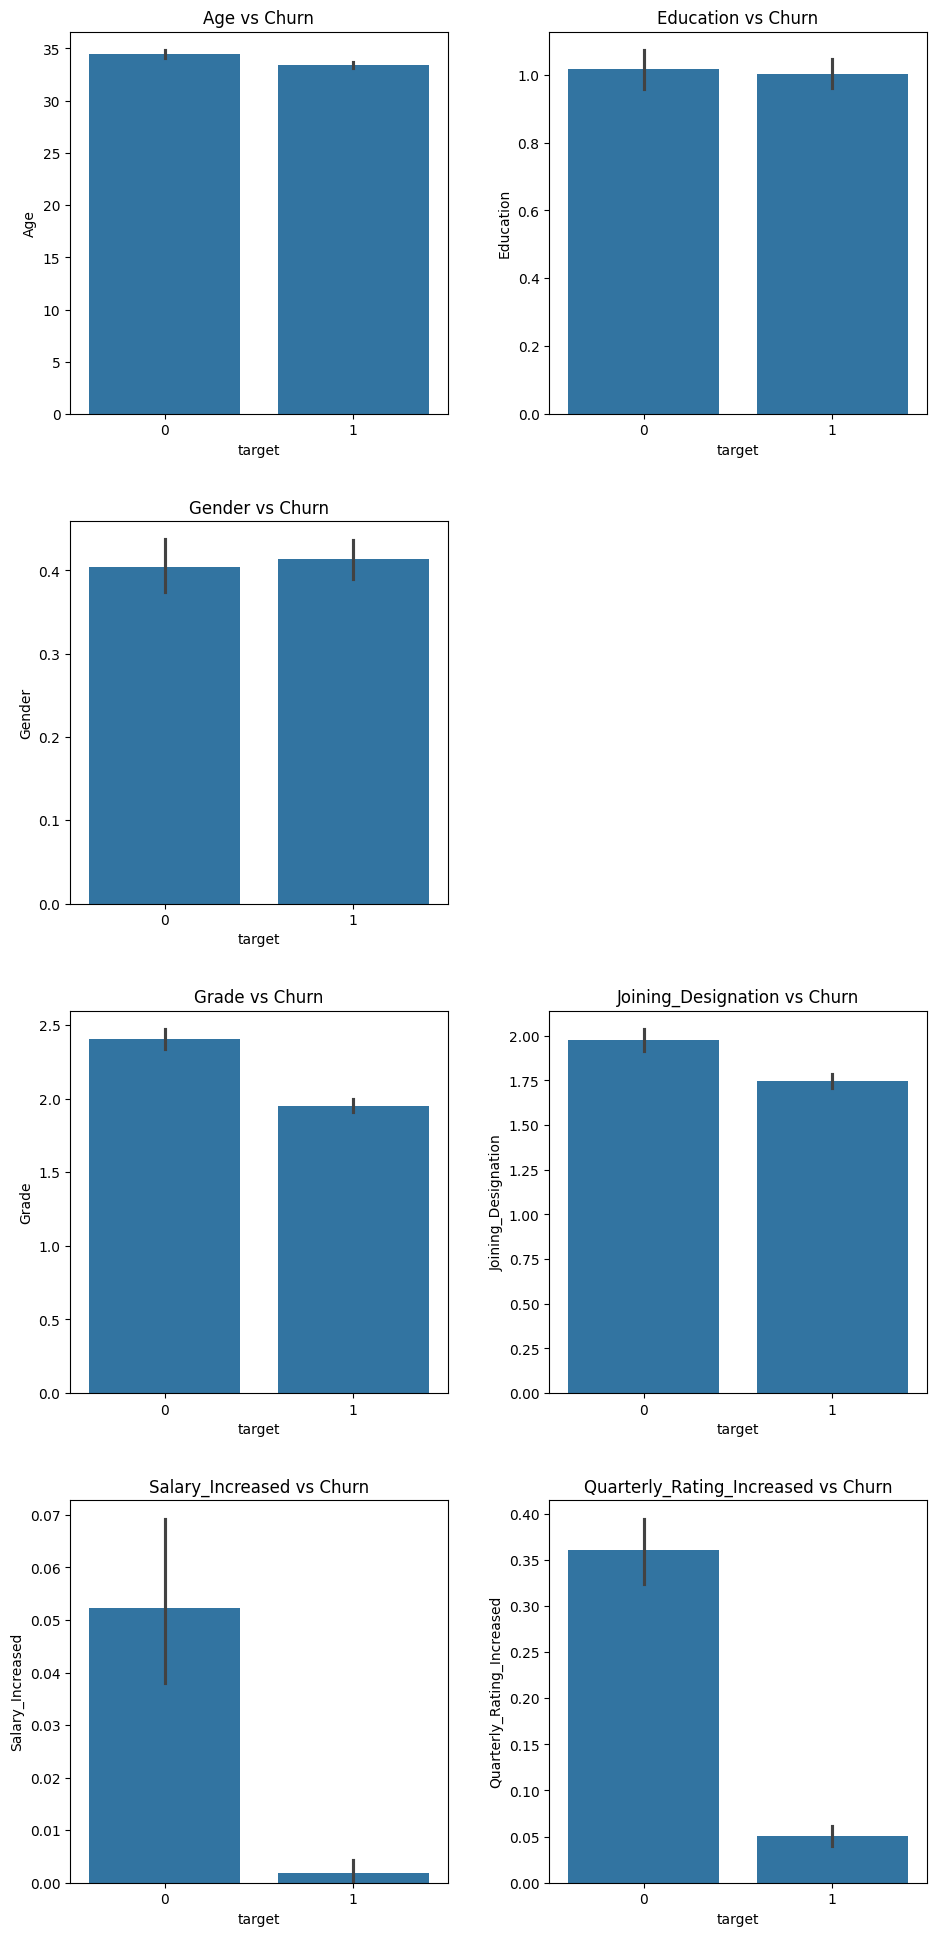

In [44]:
plt.figure(figsize=(10,20))

plt.subplot(421)
sns.barplot(data=final_data, x="target", y="Age")
plt.title("Age vs Churn")

plt.subplot(422)
sns.barplot(data=final_data, x="target", y="Education")
plt.title("Education vs Churn")

plt.subplot(423)
sns.barplot(data=final_data, x="target", y="Gender")
plt.title("Gender vs Churn")

plt.subplot(425)
sns.barplot(data=final_data, x="target", y="Grade")
plt.title("Grade vs Churn")

plt.subplot(426)
sns.barplot(data=final_data, x="target", y="Joining_Designation")
plt.title("Joining_Designation vs Churn")

plt.subplot(427)
sns.barplot(data=final_data, x="target", y="Salary_Increased")
plt.title("Salary_Increased vs Churn")

plt.subplot(428)
sns.barplot(data=final_data, x="target", y="Quarterly_Rating_Increased")
plt.title("Quarterly_Rating_Increased vs Churn")

plt.tight_layout(pad=3)

## observation

Both the departing employees and the remaining employees have almost the same percentages of age, gender, and education.

Employees with a grade of 3 or 4 when they first joined the company are less likely to quit.

Employees with higher quarterly ratings are less likely to quit the company.

Employees are more inclined to quit the company if their monthly pay has not grown.


# One-Hot Encoding


In [45]:
final_data = pd.concat([final_data, final_data['City']], axis=1)

In [46]:
final_data.shape

(2381, 14)

# Standardization

In [47]:
X = final_data.drop(["Driver_ID", "target", "City"], axis = 1)
X_cols = X.columns
scaler = MinMaxScaler()

X = scaler.fit_transform(X)

In [48]:
X = pd.DataFrame(X)

X.columns = X_cols

X

,Age,Gender,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased,Salary_Increased
0,0.189189,0.0,1.0,0.262508,0.00,0.00,0.032064,0.333333,0.0,0.0
1,0.270270,0.0,1.0,0.316703,0.25,0.25,0.014326,0.000000,0.0,0.0
2,0.594595,0.0,1.0,0.308750,0.25,0.25,0.017944,0.000000,0.0,0.0
3,0.216216,0.0,0.0,0.200489,0.00,0.00,0.015570,0.000000,0.0,0.0
4,0.270270,1.0,0.5,0.382623,0.50,0.50,0.027405,0.333333,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2376,0.351351,0.0,0.0,0.405626,0.25,0.50,0.239197,1.000000,1.0,0.0
2377,0.351351,1.0,0.0,0.007643,0.00,0.00,0.014326,0.000000,0.0,0.0
2378,0.648649,0.0,0.0,0.138588,0.25,0.25,0.043432,0.000000,0.0,0.0
2379,0.189189,1.0,1.0,0.330673,0.00,0.00,0.024436,0.000000,0.0,0.0


# Train-Test Split

In [49]:
y = final_data["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, shuffle=True)

In [50]:
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (1904, 10)
X_test Shape:  (477, 10)
y_train Shape:  (1904,)
y_test Shape:  (477,)


# Random Forest Classifier

In [51]:
params = {
    "max_depth": [2, 3, 4],
    "n_estimators": [50, 100, 150, 200],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced")
c = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params:  {'max_depth': 4, 'n_estimators': 150}
Best Score:  0.8609420128526325

Elapsed Time:  13.122531652450562


              precision    recall  f1-score   support

           0       0.72      0.57      0.64       148
           1       0.82      0.90      0.86       329

    accuracy                           0.80       477
   macro avg       0.77      0.74      0.75       477
weighted avg       0.79      0.80      0.79       477



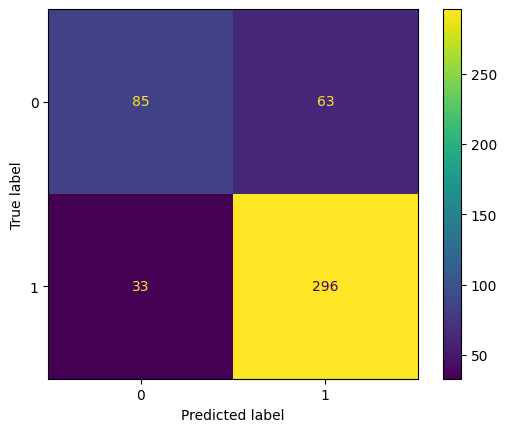

In [52]:
y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

Random Forest Classifier with balanced class weight

The precision of all predictions is 73% for properly predicting 0 and 82% for successfully predicting 1.

The measure for correctly predicting out of all actual 0 is 57%, while for 1 it is 90%.

As this is imbalanced dataset. We give importance to F1-Score metrics

F1 Score of 0 is 64%

F! Score of 1 is 86%


In [53]:
params = {
    "max_depth": [2, 3, 4],
    "n_estimators": [50, 100, 150, 200],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced_subsample")
c = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params:  {'max_depth': 4, 'n_estimators': 200}
Best Score:  0.8613810420590081

Elapsed Time:  14.0277681350708


              precision    recall  f1-score   support

           0       0.73      0.57      0.64       148
           1       0.83      0.91      0.86       329

    accuracy                           0.80       477
   macro avg       0.78      0.74      0.75       477
weighted avg       0.80      0.80      0.80       477



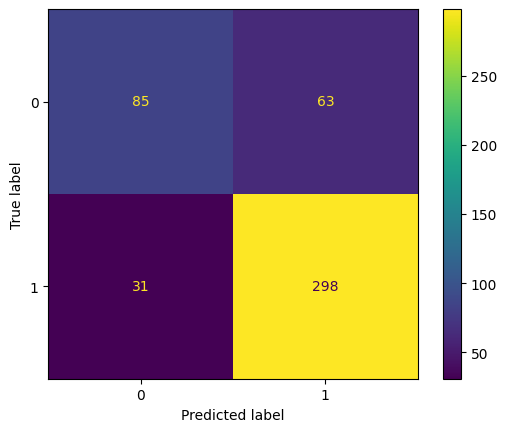

In [54]:
y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

Random Forest Classifier with balanced class weight

The measure for successfully predicting 0 out of all predictions is 75%, while for accurately predicting 1, it is 83%.

The measure for properly predicting out of all actual 0 is 57%, while for 1 it is 91%.

As this is imbalanced dataset. We give importance to F1-Score metrics

F1 Score of 0 is 65%

F! Score of 1 is 87%


# Balancing Dataset using SMOTE

In [55]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE(random_state = 7)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 1287
Before OverSampling, counts of label '0': 617 

After OverSampling, the shape of train_X: (2574, 10)
After OverSampling, the shape of train_y: (2574,) 

After OverSampling, counts of label '1': 1287
After OverSampling, counts of label '0': 1287


<ipython-input-55-c0c45e2643dd>:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train, y_train = sm.fit_resample(X_train, y_train.ravel())
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-le

# Bagging

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params:  {'max_depth': 4, 'n_estimators': 100}
Best Score:  0.7832383397571004

Elapsed Time:  14.76900839805603
              precision    recall  f1-score   support

           0       0.73      0.57      0.64       148
           1       0.83      0.91      0.86       329

    accuracy                           0.80       477
   macro avg       0.78      0.74      0.75       477
weighted avg       0.80      0.80      0.80       477



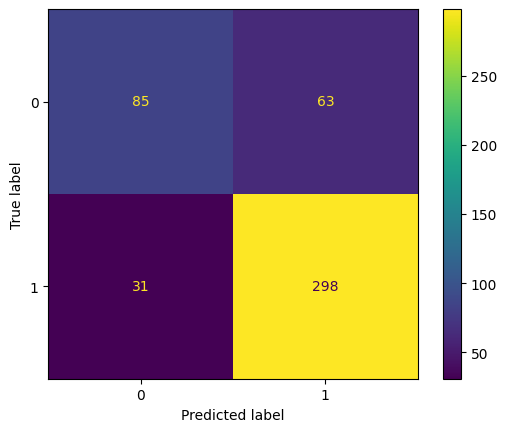

In [56]:
params = {
    "max_depth": [2, 3, 4],
    "n_estimators": [50, 100, 150, 200],
}

start_time = time.time()
random_forest = RandomForestClassifier(class_weight="balanced_subsample")
c = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1, cv=3, verbose=True, scoring='f1')

c.fit(X_train, y_train)

print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)
elapsed_time = time.time() - start_time

print("\nElapsed Time: ", elapsed_time)

y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

Random Forest Classifier with balanced class weight

The metric for successfully predicting 0 out of all predictions is 74%, while for accurately predicting 1, it is 83%.

The metric for properly predicting out of all actual 0 is 57%, and for 1 it is 91%.

As this is imbalanced dataset. We give importance to F1-Score metrics

F1 Score of 0 is 65%

F! Score of 1 is 87%

# ROC-AUC Curve

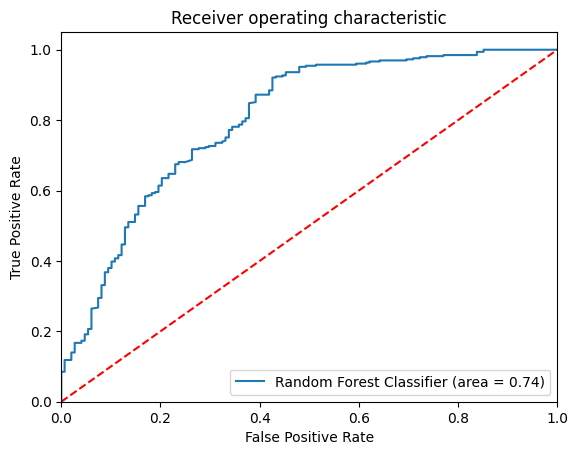

In [57]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Boosting

## Gradient Boosting Classifier



Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best Params:  {'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 4, 'n_estimators': 150, 'subsample': 1}
Best Score:  0.8146853146853147

 Elapsed Time:  354.44513630867004
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       148
           1       0.82      0.83      0.83       329

    accuracy                           0.76       477
   macro avg       0.72      0.72      0.72       477
weighted avg       0.76      0.76      0.76       477



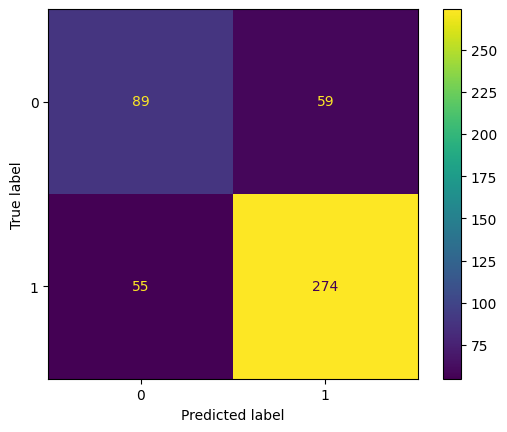

In [58]:
params = {
    "max_depth": [2, 3, 4],
    "loss": ["log_loss", "exponential"],
    "subsample": [0.1, 0.2, 0.5, 0.8, 1],
    "learning_rate": [0.1, 0.2, 0.3],
    "n_estimators": [50,100,150,200]
}

gbdt = GradientBoostingClassifier()
start_time = time.time()
c = GridSearchCV(estimator=gbdt, cv=3, n_jobs=-1, verbose=True, param_grid=params)

c.fit(X_train, y_train)
print("Best Params: ", c.best_params_)
print("Best Score: ", c.best_score_)

elapsed_time = time.time() - start_time
print("\n Elapsed Time: ", elapsed_time)

y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=c.classes_).plot()

Gradient Boosting Classifier Metrics

The percentage of all predictions that were accurately predicted for 0 and 1 is 62% and 82%, respectively.

The measure for properly predicting out of all actual 0 is 60%, and for 1 it is 83%.

As this is imbalanced dataset. We give importance to F1-Score metrics

F1 Score of 0 is 61%

F1 Score of 1 is 83%

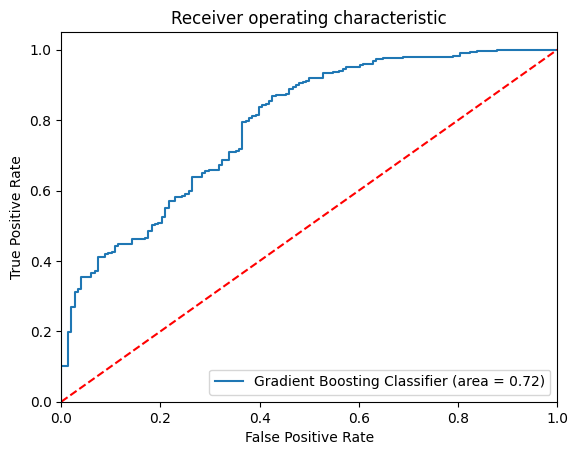

In [59]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Gradient Boosting Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# XGBoost Classifier

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:32:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier Score:  0.7547169811320755

               precision    recall  f1-score   support

           0       0.60      0.63      0.61       148
           1       0.83      0.81      0.82       329

    accuracy                           0.75       477
   macro avg       0.71      0.72      0.72       477
weighted avg       0.76      0.75      0.76       477



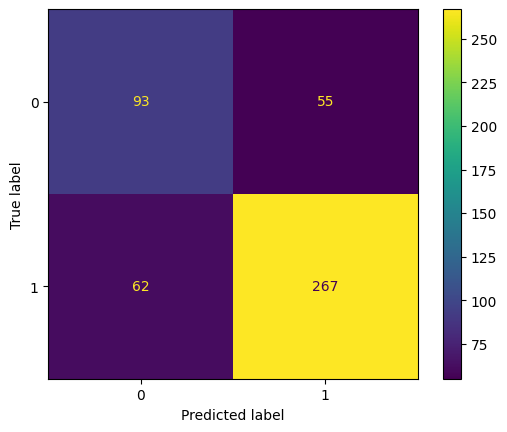

In [60]:
model = xgb.XGBClassifier(class_weight = "balanced")

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("XGBoost Classifier Score: ", model.score(X_test, y_test))
print("\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

XGBoost Classifier with balanced class weight

The measure for successfully predicting 0 out of all predictions is 62%, while for accurately predicting 1, it is 81%.

The measure for properly predicting out of all actual 0 is 57%, while for 1 it is 84%.

As this is imbalanced dataset. We give importance to F1-Score metrics

F1 Score of 0 is 60%

F1 Score of 1 is 83%

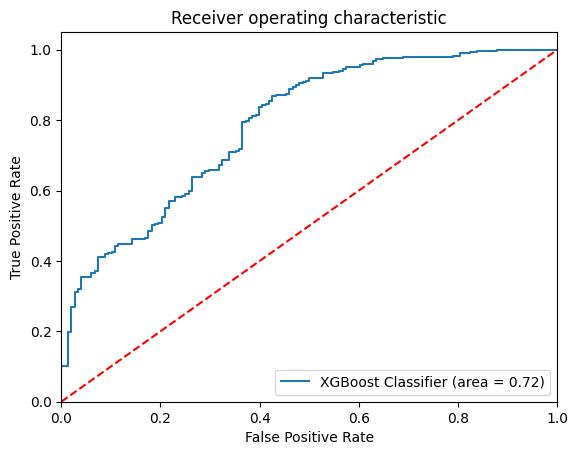

In [61]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,c.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='XGBoost Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Feature Importance of the best model

Random Forest Classifier outperforms the rest of the modal.

Best parameters

Best Params: {'max_depth': 4, 'n_estimators': 50}

In [62]:
rf = RandomForestClassifier(max_depth = 4, n_estimators= 50, class_weight="balanced")

rf.fit(X_train, y_train)
print("Score of RandomForestClassifier: ", rf.score(X_test, y_test))

Score of RandomForestClassifier:  0.8029350104821803


In [63]:
importances = rf.feature_importances_
importances

array([0.02858582, 0.00135297, 0.00364675, 0.04710863, 0.0569109 ,
       0.06473531, 0.27548394, 0.31695869, 0.19897633, 0.00624067])

In [64]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

<Figure size 1500x700 with 0 Axes>

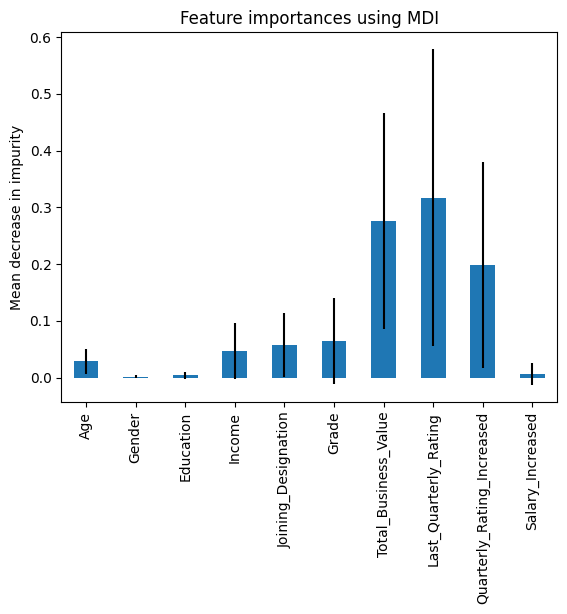

In [65]:
feature_importances = pd.Series(importances, X_train.columns)

plt.figure(figsize=(15,7))
fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

plt.show()

Last_Quarterly_Rating, Total_Business_Value & Quarterly_Rating_Increased are the most important features.


# Insights and Recommendations

A significant number of drivers (1616 out of 2381) have left the company.

Drivers with improved quarterly ratings are less likely to leave.

Drivers with stagnant salaries are more prone to leaving.

1744 employees had a "1" in their last quarterly rating, indicating potential performance issues.

Implement a robust incentive program to retain top-performing drivers. This could include bonuses, promotions, or other perks.

Proactively address salary concerns for employees with stagnant salaries. Explore options like performance-based bonuses or skill-development programs to increase earning potential.

Focus on improving the performance management system. Address the root causes of low quarterly ratings and provide necessary support or training to help drivers improve.

Encourage and incentivize customers to rate drivers. Analyze customer feedback to identify areas for improvement and provide constructive feedback to drivers.


